## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019c'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 10 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([10, 224, 224])

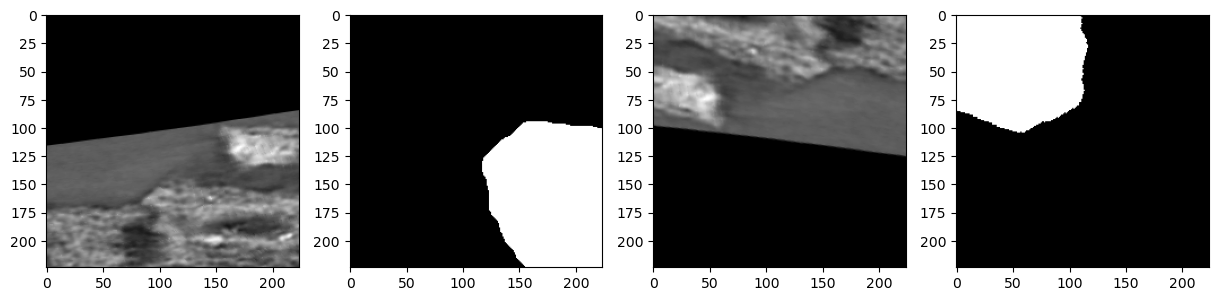

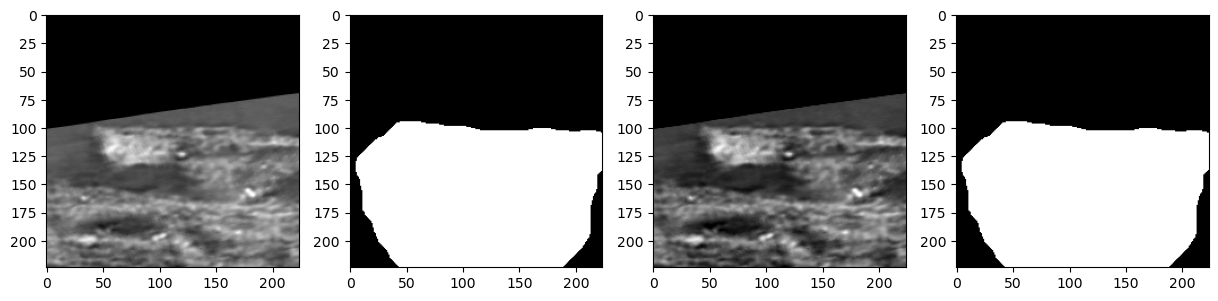

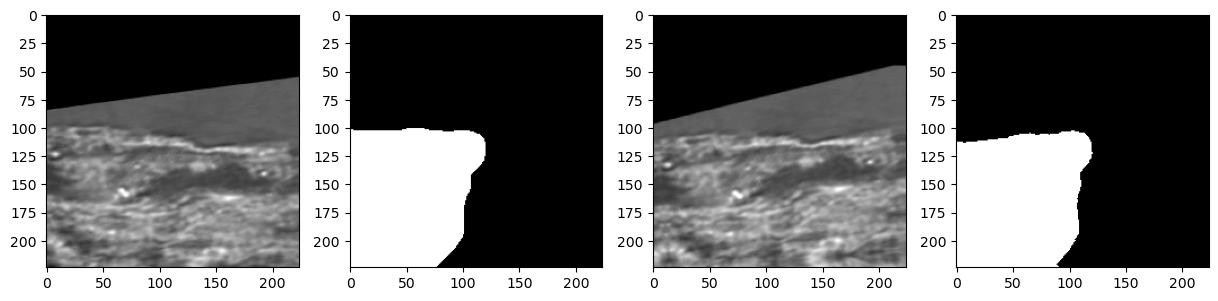

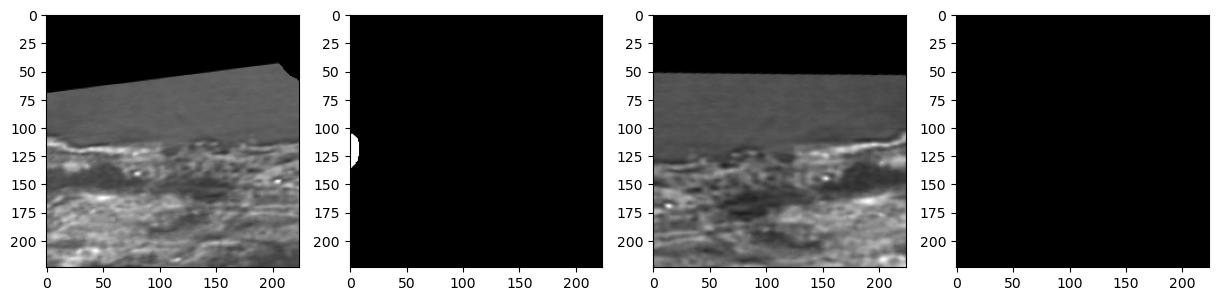

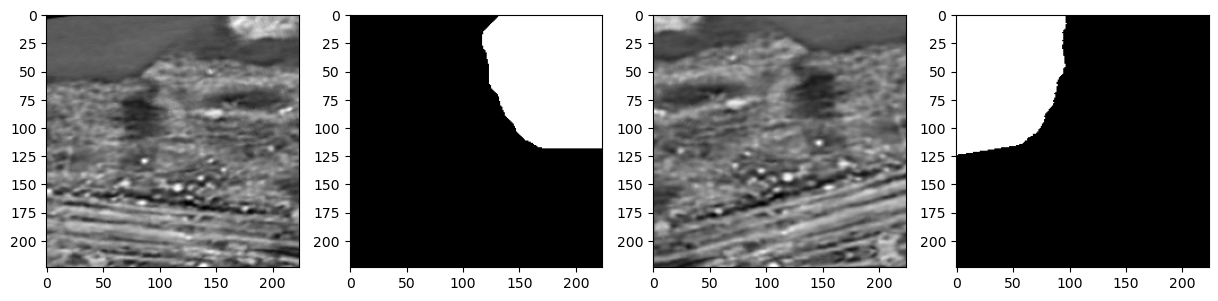

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1420906718541402
th: 0.15, fbeta: 0.1420689228915206
th: 0.2, fbeta: 0.14195274115425952
th: 0.25, fbeta: 0.14152602529454963
th: 0.3, fbeta: 0.1956892635435539
th: 0.35, fbeta: 0.21581997068112246
th: 0.4, fbeta: 0.22963747087461947
th: 0.45, fbeta: 0.2387590745854691


best_th: 0.45, fbeta: 0.2387590745854691
Epoch 1 - avg_train_loss: 0.6544  avg_val_loss: 0.5139  time: 119s
Epoch 1 - avgScore: 0.2388
Epoch 1 - Save Best Score: 0.2388 Model
Epoch 1 - Save Best Loss: 0.5139 Model


th: 0.5, fbeta: 0.2338587329001447


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209333965487253
th: 0.15, fbeta: 0.14209149876859886
th: 0.2, fbeta: 0.14220540640791443
th: 0.25, fbeta: 0.20439567531963582
th: 0.3, fbeta: 0.23165593290533193
th: 0.35, fbeta: 0.26123307535877316
th: 0.4, fbeta: 0.24159182881319632
th: 0.45, fbeta: 0.18372546020110073


best_th: 0.35, fbeta: 0.26123307535877316
Epoch 2 - avg_train_loss: 0.4548  avg_val_loss: 0.4239  time: 122s
Epoch 2 - avgScore: 0.2612
Epoch 2 - Save Best Score: 0.2612 Model
Epoch 2 - Save Best Loss: 0.4239 Model


th: 0.5, fbeta: 0.12407921904386664


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.33172643744378216
th: 0.15, fbeta: 0.32238857020029493
th: 0.2, fbeta: 0.2743448938420317
th: 0.25, fbeta: 0.2248808641724527
th: 0.3, fbeta: 0.17833067230489022
th: 0.35, fbeta: 0.1381498231892036
th: 0.4, fbeta: 0.1048860177803099
th: 0.45, fbeta: 0.07602903555767127


best_th: 0.1, fbeta: 0.33172643744378216
Epoch 3 - avg_train_loss: 0.2897  avg_val_loss: 0.3416  time: 121s
Epoch 3 - avgScore: 0.3317
Epoch 3 - Save Best Score: 0.3317 Model
Epoch 3 - Save Best Loss: 0.3416 Model


th: 0.5, fbeta: 0.05013764066429282


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29317362025115395
th: 0.15, fbeta: 0.23287849538150987
th: 0.2, fbeta: 0.1712928199272004
th: 0.25, fbeta: 0.12251610839979778
th: 0.3, fbeta: 0.0870995267329535
th: 0.35, fbeta: 0.06305432364399637
th: 0.4, fbeta: 0.04671311702241599
th: 0.45, fbeta: 0.03395206115695869


best_th: 0.1, fbeta: 0.29317362025115395
Epoch 4 - avg_train_loss: 0.2141  avg_val_loss: 0.3976  time: 121s
Epoch 4 - avgScore: 0.2932


th: 0.5, fbeta: 0.024227530211844383


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3014327081816594
th: 0.15, fbeta: 0.2534133007681176
th: 0.2, fbeta: 0.20055866132667977
th: 0.25, fbeta: 0.15607651730461022
th: 0.3, fbeta: 0.11885166855439164
th: 0.35, fbeta: 0.08639921913194204
th: 0.4, fbeta: 0.062342777248168085
th: 0.45, fbeta: 0.04417150857857525


best_th: 0.1, fbeta: 0.3014327081816594
Epoch 5 - avg_train_loss: 0.1939  avg_val_loss: 0.4307  time: 120s
Epoch 5 - avgScore: 0.3014


th: 0.5, fbeta: 0.029598829487255347


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.355745351290434
th: 0.15, fbeta: 0.3117039280650633
th: 0.2, fbeta: 0.25775924936243233
th: 0.25, fbeta: 0.20534687145380529
th: 0.3, fbeta: 0.16174551554877659
th: 0.35, fbeta: 0.1243110240492975
th: 0.4, fbeta: 0.09401552253142267
th: 0.45, fbeta: 0.06776763086364825


best_th: 0.1, fbeta: 0.355745351290434
Epoch 6 - avg_train_loss: 0.1803  avg_val_loss: 0.4035  time: 120s
Epoch 6 - avgScore: 0.3557
Epoch 6 - Save Best Score: 0.3557 Model
Epoch 6 - Save Best Loss: 0.4035 Model


th: 0.5, fbeta: 0.04819350419701606


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4059949703429983
th: 0.15, fbeta: 0.40985149875643023
th: 0.2, fbeta: 0.39974292679567125
th: 0.25, fbeta: 0.3808106761307393
th: 0.3, fbeta: 0.35865160103553
th: 0.35, fbeta: 0.3313008704980336
th: 0.4, fbeta: 0.30132600031508755
th: 0.45, fbeta: 0.26886918190377446


best_th: 0.15, fbeta: 0.40985149875643023
Epoch 7 - avg_train_loss: 0.1683  avg_val_loss: 0.4298  time: 121s
Epoch 7 - avgScore: 0.4099
Epoch 7 - Save Best Score: 0.4099 Model
Epoch 7 - Save Best Loss: 0.4298 Model


th: 0.5, fbeta: 0.23531011566251903


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3710562352522138
th: 0.15, fbeta: 0.37890763449210785
th: 0.2, fbeta: 0.3785149885084052
th: 0.25, fbeta: 0.37420685151271316
th: 0.3, fbeta: 0.36171245004072444
th: 0.35, fbeta: 0.34247172767067774
th: 0.4, fbeta: 0.317765263656587
th: 0.45, fbeta: 0.2907769150000125


best_th: 0.15, fbeta: 0.37890763449210785
Epoch 8 - avg_train_loss: 0.1562  avg_val_loss: 0.4128  time: 122s
Epoch 8 - avgScore: 0.3789


th: 0.5, fbeta: 0.26169008741110006


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3854796707848817
th: 0.15, fbeta: 0.39721929731993594
th: 0.2, fbeta: 0.4016840597401683
th: 0.25, fbeta: 0.39968097806181846
th: 0.3, fbeta: 0.39285406095002917
th: 0.35, fbeta: 0.3796860646421199
th: 0.4, fbeta: 0.36166158461201
th: 0.45, fbeta: 0.3381858397665464


best_th: 0.2, fbeta: 0.4016840597401683
Epoch 9 - avg_train_loss: 0.1465  avg_val_loss: 0.4566  time: 121s
Epoch 9 - avgScore: 0.4017


th: 0.5, fbeta: 0.3126957362798879


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3684787481274085
th: 0.15, fbeta: 0.3542652807483987
th: 0.2, fbeta: 0.3341159636900003
th: 0.25, fbeta: 0.310837236469045
th: 0.3, fbeta: 0.28508346182351185
th: 0.35, fbeta: 0.2567554023527474
th: 0.4, fbeta: 0.22803326025659137
th: 0.45, fbeta: 0.19729001009280964


best_th: 0.1, fbeta: 0.3684787481274085
Epoch 10 - avg_train_loss: 0.1356  avg_val_loss: 0.5060  time: 119s
Epoch 10 - avgScore: 0.3685


th: 0.5, fbeta: 0.16692492683830049


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34760149186899403
th: 0.15, fbeta: 0.3384796693287794
th: 0.2, fbeta: 0.3234010932982547
th: 0.25, fbeta: 0.30779280544281595
th: 0.3, fbeta: 0.2919057406793281
th: 0.35, fbeta: 0.27060910349081607
th: 0.4, fbeta: 0.24648534060749427
th: 0.45, fbeta: 0.22359491036598572


best_th: 0.1, fbeta: 0.34760149186899403
Epoch 11 - avg_train_loss: 0.1282  avg_val_loss: 0.5449  time: 119s
Epoch 11 - avgScore: 0.3476


th: 0.5, fbeta: 0.2029328759996788


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3925432663860942
th: 0.15, fbeta: 0.3654853898837537
th: 0.2, fbeta: 0.3301652017205027
th: 0.25, fbeta: 0.2964472614752236
th: 0.3, fbeta: 0.26182222118657716
th: 0.35, fbeta: 0.22734531512730166
th: 0.4, fbeta: 0.1945215911034501
th: 0.45, fbeta: 0.1631264465711321


best_th: 0.1, fbeta: 0.3925432663860942
Epoch 12 - avg_train_loss: 0.1198  avg_val_loss: 0.5436  time: 120s
Epoch 12 - avgScore: 0.3925


th: 0.5, fbeta: 0.1340801858431246


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27642357240209897
th: 0.15, fbeta: 0.23678764971201793
th: 0.2, fbeta: 0.20076021833126376
th: 0.25, fbeta: 0.17101376983553374
th: 0.3, fbeta: 0.14561359621403597
th: 0.35, fbeta: 0.12386820402974111
th: 0.4, fbeta: 0.10355154416076866
th: 0.45, fbeta: 0.08492542508487384


best_th: 0.1, fbeta: 0.27642357240209897
Epoch 13 - avg_train_loss: 0.1110  avg_val_loss: 0.6811  time: 120s
Epoch 13 - avgScore: 0.2764


th: 0.5, fbeta: 0.0669951067824178


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3852254980518076
th: 0.15, fbeta: 0.3739778021586865
th: 0.2, fbeta: 0.3580807243089295
th: 0.25, fbeta: 0.3406756439918288
th: 0.3, fbeta: 0.32163208212040967
th: 0.35, fbeta: 0.30187737312900015
th: 0.4, fbeta: 0.2809683835735301
th: 0.45, fbeta: 0.2580077821336421


best_th: 0.1, fbeta: 0.3852254980518076
Epoch 14 - avg_train_loss: 0.1083  avg_val_loss: 0.6459  time: 119s
Epoch 14 - avgScore: 0.3852


th: 0.5, fbeta: 0.23152323361297333


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3300823192066985
th: 0.15, fbeta: 0.2987928519946008
th: 0.2, fbeta: 0.2676508045893755
th: 0.25, fbeta: 0.23948764575251677
th: 0.3, fbeta: 0.2114341116356213
th: 0.35, fbeta: 0.18568198462878388
th: 0.4, fbeta: 0.16336200866090222
th: 0.45, fbeta: 0.14027915145907438


best_th: 0.1, fbeta: 0.3300823192066985
Epoch 15 - avg_train_loss: 0.1019  avg_val_loss: 0.6464  time: 120s
Epoch 15 - avgScore: 0.3301


th: 0.5, fbeta: 0.11891941873052132


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39141817370084564
th: 0.15, fbeta: 0.39299731395916604
th: 0.2, fbeta: 0.39055803770371245
th: 0.25, fbeta: 0.38201076080922663
th: 0.3, fbeta: 0.3700658007137902
th: 0.35, fbeta: 0.35868577716968664
th: 0.4, fbeta: 0.34626444664976985
th: 0.45, fbeta: 0.3278752114213942


best_th: 0.15, fbeta: 0.39299731395916604
Epoch 16 - avg_train_loss: 0.0934  avg_val_loss: 0.6098  time: 119s
Epoch 16 - avgScore: 0.3930


th: 0.5, fbeta: 0.3039913626645598


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35520437458955995
th: 0.15, fbeta: 0.3330550409423405
th: 0.2, fbeta: 0.3077322092407796
th: 0.25, fbeta: 0.2792730859740203
th: 0.3, fbeta: 0.2509679353223198
th: 0.35, fbeta: 0.22398092807185546
th: 0.4, fbeta: 0.19526830970827408
th: 0.45, fbeta: 0.16704414102470294


best_th: 0.1, fbeta: 0.35520437458955995
Epoch 17 - avg_train_loss: 0.0900  avg_val_loss: 0.7062  time: 120s
Epoch 17 - avgScore: 0.3552


th: 0.5, fbeta: 0.1410565828610536


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33116835248721604
th: 0.15, fbeta: 0.31472562978980373
th: 0.2, fbeta: 0.29481524395788555
th: 0.25, fbeta: 0.27320911069537557
th: 0.3, fbeta: 0.24908453053407192
th: 0.35, fbeta: 0.22466974925151806
th: 0.4, fbeta: 0.2004797652106804
th: 0.45, fbeta: 0.17689457936832148


best_th: 0.1, fbeta: 0.33116835248721604
Epoch 18 - avg_train_loss: 0.0862  avg_val_loss: 0.7206  time: 120s
Epoch 18 - avgScore: 0.3312


th: 0.5, fbeta: 0.15793155243490342


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35521854772183215
th: 0.15, fbeta: 0.3393905034672262
th: 0.2, fbeta: 0.31958390427931005
th: 0.25, fbeta: 0.30008979113419004
th: 0.3, fbeta: 0.2814554703738051
th: 0.35, fbeta: 0.26059534891920716
th: 0.4, fbeta: 0.23831496686009254
th: 0.45, fbeta: 0.21521855401667256


best_th: 0.1, fbeta: 0.35521854772183215
Epoch 19 - avg_train_loss: 0.0807  avg_val_loss: 0.7358  time: 119s
Epoch 19 - avgScore: 0.3552


th: 0.5, fbeta: 0.19239586649569415


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3198760126431789
th: 0.15, fbeta: 0.29570209795438923
th: 0.2, fbeta: 0.2703417888643997
th: 0.25, fbeta: 0.24129978381269743
th: 0.3, fbeta: 0.21719611261720329
th: 0.35, fbeta: 0.19473090881908187
th: 0.4, fbeta: 0.1733413719131132
th: 0.45, fbeta: 0.15232247239832758


best_th: 0.1, fbeta: 0.3198760126431789
Epoch 20 - avg_train_loss: 0.0770  avg_val_loss: 0.7922  time: 120s
Epoch 20 - avgScore: 0.3199


th: 0.5, fbeta: 0.13323117485471075


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3243247439612331
th: 0.15, fbeta: 0.3039637028227213
th: 0.2, fbeta: 0.27853672749770914
th: 0.25, fbeta: 0.2534862690074936
th: 0.3, fbeta: 0.22923310544478648
th: 0.35, fbeta: 0.20752345774143777
th: 0.4, fbeta: 0.18416090715586822
th: 0.45, fbeta: 0.1605067740484105


best_th: 0.1, fbeta: 0.3243247439612331
Epoch 21 - avg_train_loss: 0.0732  avg_val_loss: 0.8204  time: 120s
Epoch 21 - avgScore: 0.3243


th: 0.5, fbeta: 0.13950489503288008


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3324358262089877
th: 0.15, fbeta: 0.3142459162232827
th: 0.2, fbeta: 0.29198001807101975
th: 0.25, fbeta: 0.26821374088627176
th: 0.3, fbeta: 0.24517122091136695
th: 0.35, fbeta: 0.22244739618499013
th: 0.4, fbeta: 0.19958269362610576
th: 0.45, fbeta: 0.17791677346037843


best_th: 0.1, fbeta: 0.3324358262089877
Epoch 22 - avg_train_loss: 0.0686  avg_val_loss: 0.7971  time: 119s
Epoch 22 - avgScore: 0.3324


th: 0.5, fbeta: 0.15817466674017552


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33343962891859713
th: 0.15, fbeta: 0.3179880299870027
th: 0.2, fbeta: 0.30038497195942493
th: 0.25, fbeta: 0.27761135954145627
th: 0.3, fbeta: 0.25572159411345646
th: 0.35, fbeta: 0.23601418132964352
th: 0.4, fbeta: 0.2168929356484244
th: 0.45, fbeta: 0.1975701978990837


best_th: 0.1, fbeta: 0.33343962891859713
Epoch 23 - avg_train_loss: 0.0666  avg_val_loss: 0.8236  time: 120s
Epoch 23 - avgScore: 0.3334


th: 0.5, fbeta: 0.17686368003207822


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34516813876354235
th: 0.15, fbeta: 0.3267319469713502
th: 0.2, fbeta: 0.30534985735560766
th: 0.25, fbeta: 0.27961082177845475
th: 0.3, fbeta: 0.25645873091300064
th: 0.35, fbeta: 0.2341259203850422
th: 0.4, fbeta: 0.21310381329441774
th: 0.45, fbeta: 0.19144554253402335


best_th: 0.1, fbeta: 0.34516813876354235
Epoch 24 - avg_train_loss: 0.0628  avg_val_loss: 0.7990  time: 120s
Epoch 24 - avgScore: 0.3452


th: 0.5, fbeta: 0.17069503741302752


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3551621838322857
th: 0.15, fbeta: 0.340421291671486
th: 0.2, fbeta: 0.3221885476822999
th: 0.25, fbeta: 0.298393297208837
th: 0.3, fbeta: 0.2758856288577863
th: 0.35, fbeta: 0.25426595699844373
th: 0.4, fbeta: 0.23233045573113292
th: 0.45, fbeta: 0.2098518018919404


best_th: 0.1, fbeta: 0.3551621838322857
Epoch 25 - avg_train_loss: 0.0618  avg_val_loss: 0.8034  time: 120s
Epoch 25 - avgScore: 0.3552


th: 0.5, fbeta: 0.18891947470131804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32766011448792176
th: 0.15, fbeta: 0.3060038430488916
th: 0.2, fbeta: 0.2823295556585254
th: 0.25, fbeta: 0.2544782305369278
th: 0.3, fbeta: 0.2291275009844846
th: 0.35, fbeta: 0.20547507069642992
th: 0.4, fbeta: 0.18361644025750964
th: 0.45, fbeta: 0.1619860704226991


best_th: 0.1, fbeta: 0.32766011448792176
Epoch 26 - avg_train_loss: 0.0613  avg_val_loss: 0.8509  time: 121s
Epoch 26 - avgScore: 0.3277


th: 0.5, fbeta: 0.13985793545987082


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34202052464092875
th: 0.15, fbeta: 0.3205380999217914
th: 0.2, fbeta: 0.29588579402509335
th: 0.25, fbeta: 0.26900250119262226
th: 0.3, fbeta: 0.24497128473197635
th: 0.35, fbeta: 0.22262602064470738
th: 0.4, fbeta: 0.2003900480191271
th: 0.45, fbeta: 0.17993246172580582


best_th: 0.1, fbeta: 0.34202052464092875
Epoch 27 - avg_train_loss: 0.0587  avg_val_loss: 0.8099  time: 120s
Epoch 27 - avgScore: 0.3420


th: 0.5, fbeta: 0.1589797544357234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3080937735961682
th: 0.15, fbeta: 0.2832953476964381
th: 0.2, fbeta: 0.25859708463885944
th: 0.25, fbeta: 0.23311609633090968
th: 0.3, fbeta: 0.20881276709829588
th: 0.35, fbeta: 0.18704881868477805
th: 0.4, fbeta: 0.16699619711025482
th: 0.45, fbeta: 0.1474731639790175


best_th: 0.1, fbeta: 0.3080937735961682
Epoch 28 - avg_train_loss: 0.0566  avg_val_loss: 0.8614  time: 120s
Epoch 28 - avgScore: 0.3081


th: 0.5, fbeta: 0.12786773243352298


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31514039967292534
th: 0.15, fbeta: 0.2930563070622726
th: 0.2, fbeta: 0.26908481411471197
th: 0.25, fbeta: 0.2450372979424825
th: 0.3, fbeta: 0.2230450175197968
th: 0.35, fbeta: 0.20468910282139235
th: 0.4, fbeta: 0.18489638187673377
th: 0.45, fbeta: 0.16510962146425645


best_th: 0.1, fbeta: 0.31514039967292534
Epoch 29 - avg_train_loss: 0.0558  avg_val_loss: 0.8308  time: 121s
Epoch 29 - avgScore: 0.3151


th: 0.5, fbeta: 0.1461264475971764


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30285705455064255
th: 0.15, fbeta: 0.2775361927405177
th: 0.2, fbeta: 0.25395303015935616
th: 0.25, fbeta: 0.22769802708954362
th: 0.3, fbeta: 0.203227730736136
th: 0.35, fbeta: 0.18243153624213232
th: 0.4, fbeta: 0.16148215855014403
th: 0.45, fbeta: 0.14282369793224223


best_th: 0.1, fbeta: 0.30285705455064255
Epoch 30 - avg_train_loss: 0.0555  avg_val_loss: 0.8664  time: 119s
Epoch 30 - avgScore: 0.3029


th: 0.5, fbeta: 0.12430087962100105


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4059949703429983
th: 0.15, fbeta: 0.40985149875643023
th: 0.2, fbeta: 0.39974292679567125
th: 0.25, fbeta: 0.3808106761307393
th: 0.3, fbeta: 0.35865160103553
th: 0.35, fbeta: 0.3313008704980336
th: 0.4, fbeta: 0.30132600031508755
th: 0.45, fbeta: 0.26886918190377446


best_th: 0.15, fbeta: 0.40985149875643023


th: 0.5, fbeta: 0.23531011566251903


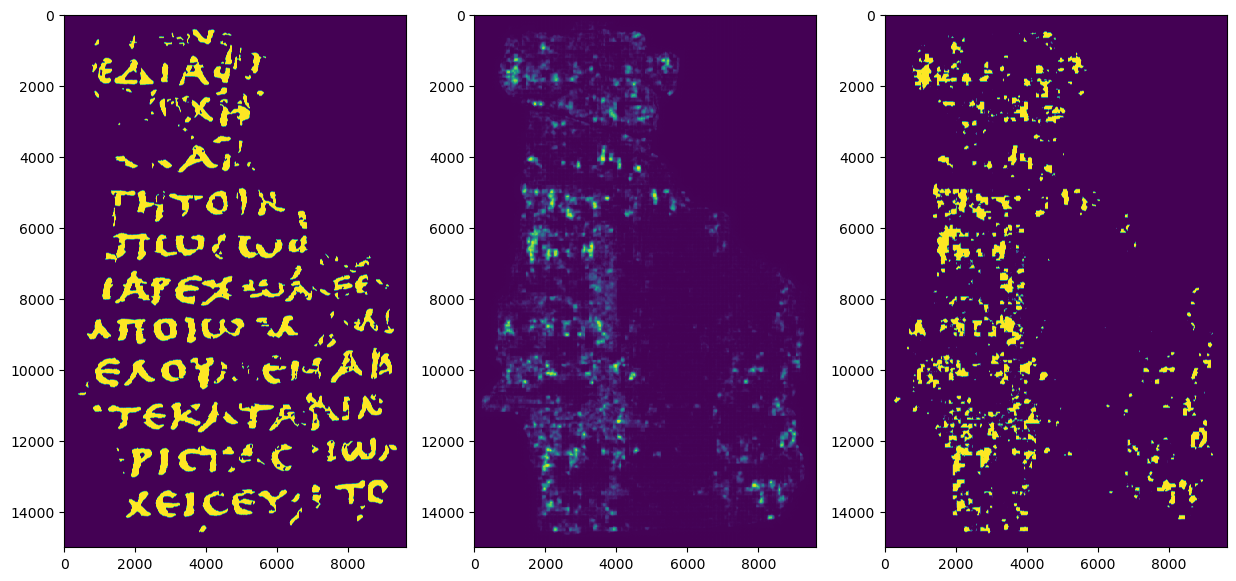

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.22265706e+08, 9.43516500e+06, 4.36992100e+06, 2.33421600e+06,
        1.42436600e+06, 9.46382000e+05, 7.50603000e+05, 5.78783000e+05,
        4.58495000e+05, 3.88025000e+05, 3.21518000e+05, 2.63723000e+05,
        2.10585000e+05, 1.90480000e+05, 1.73621000e+05, 1.53698000e+05,
        1.26347000e+05, 1.03464000e+05, 5.13660000e+04, 1.05920000e+04]),
 array([1.33814774e-04, 4.86412801e-02, 9.71487454e-02, 1.45656211e-01,
        1.94163676e-01, 2.42671141e-01, 2.91178607e-01, 3.39686072e-01,
        3.88193537e-01, 4.36701003e-01, 4.85208468e-01, 5.33715933e-01,
        5.82223398e-01, 6.30730864e-01, 6.79238329e-01, 7.27745794e-01,
        7.76253260e-01, 8.24760725e-01, 8.73268190e-01, 9.21775656e-01,
        9.70283121e-01]),
 <BarContainer object of 20 artists>)

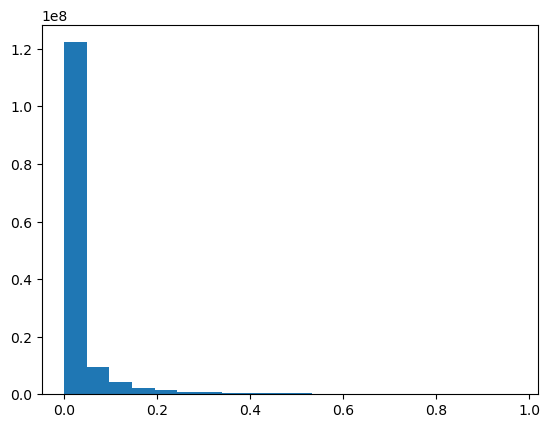

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000